In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import random

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# PART 1 - Song classification and recommendation

In [4]:
df_rec = pd.read_csv("datasets/dataset_part_1/recommendation_spotify.csv")

In [5]:
df_rec.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920
2,0.993,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920


In [6]:
print(f"{df_rec.shape[0]} chansons disponibles")

174389 chansons disponibles


## **Exercice 3**

Pour le choix des features, on sélectionne les variables numériques intrinsèques aux musique.  
Pas `year` car on ne veut pas prendre le risque de recommander que des chansons de la même année dans un système de recommentdation générique.  
Pas `duration_ms` car on ne veut pas grouper les chansons par leur durée, çe ne nous dit pas grand chose sur le sons.  
Pas `explicit` car on risque de découper notre dataset en deux parite étanche alors que une musique peut exister en version clean et explicit donc être très proche.

In [7]:
features = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]

In [8]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_rec[features])

df_features = pd.DataFrame(df_scaled, columns=features)

In [9]:
df_features.head(3)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,1.294358,0.347919,-0.948791,-0.588004,0.930106,-0.154111,-0.066549,1.089753,0.413903
1,0.378411,1.790898,0.125710,-0.510657,-0.721489,0.788862,-0.287113,-0.995485,1.608718
2,1.299622,0.626289,-1.088146,-0.589511,1.705763,-0.060991,0.374580,-0.641450,0.621861


### 1. Première approche : Similarité cosinus "Brute"

Pour répondre à la consigne de grouper les chansons par leurs caractéristiques audio, nous utilisons la **similarité cosinus**. Cette mesure calcule l'angle entre deux vecteurs (les caractéristiques normalisées de deux chansons) pour déterminer leur proximité.

1.  **Extraction** du vecteur de caractéristiques de la chanson choisie.
2.  **Calcul** de la similarité avec l'intégralité du dataset (près de 175 000 titres).
3.  **Sélection** des 10 titres ayant le score le plus proche de 1.

> **Note sur le problème des doublons :** > Dans un dataset musical comme Spotify, il est fréquent qu'un même titre apparaisse plusieurs fois (versions Remastered, Radio Edit, ou présence sur différentes compilations). Mathématiquement, ces versions sont quasiment identiques, ce qui s'avère être un défaut pour l'expérience utilisateur qui reçoit plusieurs fois la même chanson.

In [10]:
def recommend_playlist(song_name, n_recommendations=10):
    try:
        idx = df_rec[df_rec["name"].str.lower() == song_name.lower()].index[0] # On vérifie que la chanson existe
    except IndexError:
        return "Sorry, this song is not in our database."


    similarity_score = cosine_similarity([df_scaled[idx]], df_scaled)[0]

    close_indices = similarity_score.argsort()[-(n_recommendations+1):-1][::-1]

    return df_rec.iloc[close_indices][["name", "artists", "year"]]


In [11]:
#song = df_rec.iloc[0]['name']
song = "Poker Face"

print(f"Playlist recommandée pour : {song}")
recommend_playlist(song)

Playlist recommandée pour : Poker Face


,name,artists,year
16141,Poker Face,['Lady Gaga'],2020
140736,Poker Face,['Lady Gaga'],2009
17502,Poker Face,['Lady Gaga'],2008
135137,Freaky Dancin',['Cameo'],1981
173945,Bad Boy,"['Yung Bae', 'bbno$', 'Billy Marchiafava']",2019
135066,Ein Jahr (Es geht voran),['Fehlfarben'],1980
71686,Don't Stop 'Til You Get Enough,['Michael Jackson'],1995
16461,Like I Love You,['Justin Timberlake'],2002
135713,I Cry Just a Little Bit,"[""Shakin' Stevens""]",1983
139059,Aaron's Party (Come Get It),['Aaron Carter'],2000


### 2. Version améliorée : Filtrage et diversification

Afin de proposer une playlist réellement exploitable, nous avons optimisé la fonction de recommandation pour supprimer les redondances et favoriser la découverte.

**Améliorations apportées :**
* **Recherche élargie :** Au lieu de prendre les $n$ meilleures, nous analysons les $5 \times n$ chansons les plus proches. ($n$ le nombre de chansons dans la playlist)
* **Filtrage des doublons :** Nous implémentons une vérification sur les noms de titres. Si un titre a déjà été ajouté à la sélection, les versions alternatives (remasters, etc.) sont ignorées.
* **Exclusion de l'originale :** La chanson de départ est systématiquement retirée des suggestions.

**Résultat :**
Comme illustré par le test sur *"Poker Face"*, le modèle parvient désormais à sortir de l'univers strict de Lady Gaga pour proposer des "jumeaux sonores" cohérents (Michael Jackson, Justin Timberlake, Britney Spears), tout en respectant la texture audio de l'époque et du style.

In [12]:
def recommend_playlist_clean(song_name, n_recommendations=10):
    try:
        idx = df_rec[df_rec["name"].str.lower() == song_name.lower()].index[0]
        original_name = df_rec.iloc[idx]["name"]
        
        similarity_score = cosine_similarity([df_scaled[idx]], df_scaled)[0]
        
        indices_potents = similarity_score.argsort()[-5*n_recommendations:][::-1]
        
        recommendations = []
        already_seen = {original_name.lower()} # On ignore l'originale
        
        for i in indices_potents:
            row = df_rec.iloc[i]
            name = row["name"].lower()
            
            if name not in already_seen:
                recommendations.append(row)
                already_seen.add(name)
            
            if len(recommendations) >= n_recommendations:
                break
                
        return pd.DataFrame(recommendations)[["name", "artists", "year"]]
    
    except IndexError:
        return "Sorry, this song is not in our database."


In [13]:
print(f"Playlist {song} sans doublons :")
recommend_playlist_clean(song)

Playlist Poker Face sans doublons :


,name,artists,year
135137,Freaky Dancin',['Cameo'],1981
173945,Bad Boy,"['Yung Bae', 'bbno$', 'Billy Marchiafava']",2019
135066,Ein Jahr (Es geht voran),['Fehlfarben'],1980
71686,Don't Stop 'Til You Get Enough,['Michael Jackson'],1995
16461,Like I Love You,['Justin Timberlake'],2002
135713,I Cry Just a Little Bit,"[""Shakin' Stevens""]",1983
139059,Aaron's Party (Come Get It),['Aaron Carter'],2000
17614,Circus,['Britney Spears'],2008
140320,Rock This Party - Everybody Dance Now,"['Bob Sinclar', 'Cutee B.', 'DollarMan', 'Big ...",2006
39060,Ride It,['Regard'],2019


#### 3. Proposition d'architecture : système de recommandation hybride

Pour maximiser la pertinence et la diversité, nous proposons une architecture hybride combinant quatre moteurs distincts, dont les résultats sont agrégés selon des hyperparamètres ajustables ($w,x, y, z$).

##### A. Moteur collaboratif - Poids $x\%$
Ce module exploite la "sagesse de la foule" :
1.  **Clustering de Voisins :** Pour un utilisateur $U$, nous sélectionnons un pool de $m$ utilisateurs ayant un coefficient de recouvrement supérieur à un seuil $n\%$ (en traitant les remasters/versions alternatives comme une entité unique).
2.  **Voting Pondéré :** Les titres candidats sont classés selon leur fréquence d'apparition dans les playlists voisines, pondérée par la similarité entre le voisin et $U$.
   $$Score(Item) = \sum_{v \in Voisins} (Similarité(U, v) \times \mathbb{1}_{v \text{ a aimé Item}})$$

##### B. Moteur content-based (similarité audio) - Poids $y\%$
Ce module assure la continuité stylistique (exploitation) :
1.  Utilisation de la **Similarité Cosinus** dans l'espace vectoriel des features audio.
2.  Génération de jumeaux sonores pour les titres les plus écoutés par l'utilisateur.

##### C. Moteur d'exploration - Poids $z\%$
Ce module contrecarre la **Bulle de filtre** :
1.  Inspiré des algorithmes **MCTS / UCB (Upper Confidence Bound)**, ce moteur injecte des titres issus de genres ou clusters peu explorés par l'utilisateur.
2.  Il maximise une fonction de récompense à long terme (découverte) plutôt que la satisfaction immédiate.

##### D. Module d'affinité artiste - Poids $w\%$
Ce module renforce l'engagement en exploitant l'historique de fidélité :
1. **Extraction de l'affinité :** Identification des artistes favoris de l'utilisateur.
2. **Sélection de catalogue :** Extraction de titres de ces artistes qui ne sont pas encore présents dans la playlist de l'utilisateur.
3. **Pondération de confiance :** Ce module agit comme un ancrage psychologique, augmentant le taux de clic sur la playlist globale.

##### D. Agrégation et Post-Processing
La liste finale est une fusion des trois sources :
1.  **Quota :** $$w(Affinité) + x(Collaboratif) + y(Contenu) + z(Exploration)$$ Découverte.
2.  **Deduplication intelligente :** Un filtre séquentiel retire les doublons (priorité au score collaboratif) et les versions alternatives d'un même titre.
3.  **Cold start :** Pour un nouvel utilisateur, les poids basculent temporairement vers $y$ (Audio) et $z$ (Exploration) le temps de collecter des interactions ou un choix de genre préféré et lui proposer les musiques les plus populaire de ce genre actuellement.

### 3. Sytème de recommandation hybride

Pour créer la playlist idéale, nous ne nous basons pas sur un seul critère. Nous proposons une architecture qui mélange quatre ingrédients complémentaires. L'importance de chaque ingrédient est ajustable grâce à des poids ($w, x, y, z$) pour s'adapter à chaque utilisateur.

#### A. L'avis des "voisins musicaux" (Le module Collaboratif - $x\%$)
C'est le principe du bouche-à-oreille : 
* On cherche des utilisateurs qui ont des goûts très proches de l'utilisateur (sons en commun, artistes en commun, profil commun).
* On regarde ce qu'ils écoutent et que l'utilisateur ne connais pas encore pour lui suggérer.

#### B. Le "Miroir Sonore" (Le module Contenu - $y\%$)
C'est la cohérence acoustique :
* Le système analyse les propriétés mathématiques du son (le tempo, l'énergie, la présence d'instruments).
* Il cherche des "jumeaux sonores" qui ont la même ambiance que les morceaux préférés de l'utilisateur.

#### C. Sortir des bulles de filtre (Le module Exploration - $z\%$)
C'est l'outil pour briser la bulle de filtre :
* Pour éviter que l'utilisateur ne tourne en rond, ce module propose délibérément des genres ou des styles nouveaux.
* Il teste les réactions de l'utilisateur pour apprendre à mieux le connaître sur le long terme.

#### D. La zone de confort (Le module Artiste - $w\%$)
* On identifie les artistes favoris de l'utilisateur pour lui proposer leurs morceaux que vous n'avez pas encore ajoutés.
* Cela crée un sentiment de confiance immédiat envers la playlist.

---

### Synthèse et Nettoyage
Le résultat final est une fusion de ces quatre sources. Nous appliquons ensuite un **filtre intelligent** pour :
1. **Éliminer les doublons :** On évite de proposer plusieurs fois la même chanson sous différentes versions (Remastered, Deluxe, etc.).
2. **Gérer les nouveaux utilisateurs :** Si un utilisateur vient d'arriver, le système se base sur ses genres préférés et sur les titres les plus populaires du moment, le temps d'apprendre à connaître ses goûts.

### 4. Le moteur

In [14]:
from recommendation_utils import RecommendationEngine, User, plot_profiles_side_by_side, compare_user, find_and_add

In [15]:
GENERATE_USER = False

In [16]:
engine = RecommendationEngine("datasets/dataset_part_1/recommendation_spotify.csv")

In [24]:
def generate_user_database(engine, n_stereotypes=5, n_realistes=20, filename="out_exercice3/users_db.csv"):
    print("Génération de la base d'utilisateurs...")
    users_data = []
    
    # On définit des archétypes
    archetypes = {
        'Rock_Fan': ["Deftones", "Nirvana", "Metallica", "The Beatles", "Pink Floyd", "AC/DC", "Led Zeppelin", "Guns N'Roses"],
        'Pop_Fan': ["Taylor Swift", "Ed Sheeran", "Ariana Grande", "Justin Bieber", "Katy Perry", "Rihanna", "Lady Gaga", "Bruno Mars"],
        'Rap_Fan': ["Eminem", "Drake", "Kanye West", "Jay-Z", "Travis Scott", "Kendrick Lamar", "Juice WRLD", "Kendrick Lamar"],
        'Jazz_Soul_Fan': ["Miles Davis", "Frank Sinatra", "Nina Simone", "Ray Charles", "Aretha Franklin", "Louis Armstrong"],
        'Electro_Fan': ["Daft Punk", "Avicii", "Calvin Harris", "David Guetta", "Skrillex", "The Chainsmokers", "Marshmello"]
    }

    #On créer des user stéréotypés
    for genre, artists in archetypes.items():
        for i in range(n_stereotypes):
            user_id = f"{genre}_{i+1}"
            liked_indices = []
            
            for _ in range(random.randint(10, 20)):

                artist = random.choice(artists)
                songs = engine.df[engine.df["artists"].str.contains(artist, case=False, regex=False)]

                if not songs.empty:

                    song_idx = int(songs.sample(1).index[0])
                    liked_indices.append(song_idx)
            

            users_data.append({"user_id": user_id, "liked_indices": list(set(liked_indices))})


    #On créer des utilisateurs réalistes -> On prends un cluster au hasard et on pioche dedans
    for i in range(n_realistes):
        user_id = f"User_Realiste_{i+1}"
        liked_indices = []
        
        clusters_pref = random.sample(range(20), 2) # On prends 2 genres
        
        for cluster in clusters_pref:

            candidates = engine.df[engine.df["cluster"] == cluster]

            if not candidates.empty:

                selection = candidates.sample(min(len(candidates), random.randint(5, 10)))
                indices_clean = [int(x) for x in selection.index.tolist()]
                liked_indices.extend(selection.index.tolist())
                
        users_data.append({"user_id": user_id, "liked_indices": list(set(liked_indices))})

    # Génération de nouveaux user
    users_data.append({"user_id": "New_User_1", "liked_indices": []})
    users_data.append({"user_id": "New_User_2", "liked_indices": []})

    df_users = pd.DataFrame(users_data)
    df_users.to_csv(filename, index=False)
    print(f"Base de données générée : {len(df_users)} utilisateurs sauvegardés dans '{filename}'")
    return df_users


In [18]:
def load_users(engine, filename="out_exercice3/users_db.csv"):
    print(f"Chargement des utilisateurs depuis {filename}...")
    df_users = pd.read_csv(filename)
    user_pool = []
    
    for _, row in df_users.iterrows():
        user = User(row["user_id"])
        
        try:
            indices = ast.literal_eval(str(row["liked_indices"]))
            
            for idx in indices:
                if idx < len(engine.df):
                    song_row = engine.df.iloc[idx]
                    user.add_liked_song(song_row, idx)
            
            user_pool.append(user)
        except Exception as e:
            print(f"Erreur chargement user {row['user_id']}: {e}")
            
    print(f"{len(user_pool)} utilisateurs chargés en mémoire")
    return user_pool


In [ ]:
#GENERATE_USER = True

In [26]:
if GENERATE_USER:
    generate_user_database(engine)

Génération de la base d'utilisateurs...
Base de données générée : 47 utilisateurs sauvegardés dans 'out_exercice3/users_db.csv'


In [27]:
user_pool = load_users(engine)

Chargement des utilisateurs depuis out_exercice3/users_db.csv...
47 utilisateurs chargés en mémoire


#### La Similarité hybride  

Le défi majeur de la recommandation est la "sparsité" : deux fans de Rock peuvent n'avoir aucune chanson en commun dans leurs playlists respectives. Notre moteur résout cela en calculant une similarité hybride :

Exact match (20%) : Chansons identiques.

Artist match (50%) : Artistes en commun.

Features match (30%) : Proximité des caractéristiques audio.

In [28]:
user_a = next(u for u in user_pool if u.user_id == "Rock_Fan_1")
user_b = next(u for u in user_pool if u.user_id == "Rock_Fan_2")

sim_pure = len(user_a.liked_keys.intersection(user_b.liked_keys)) / len(user_a.liked_keys.union(user_b.liked_keys)) if len(user_a.liked_keys.union(user_b.liked_keys)) > 0 else 0
sim_hybride = user_a.get_similarity(user_b, engine)

print(f"----- ANALYSE DE SIMILARITÉ -----\n{user_a.user_id} vs {user_b.user_id}")
print(f"Similarité Chansons uniquement : {sim_pure:.2%}")
print(f"Similarité hybride (artistes + audio) : {sim_hybride:.2%}")


----- ANALYSE DE SIMILARITÉ -----
Rock_Fan_1 vs Rock_Fan_2
Similarité Chansons uniquement : 3.57%
Similarité hybride (artistes + audio) : 60.71%


Si la similarité pure est à 0% alors que l'hybride est à 30-40%, cela prouve que le moteur a réussi à détecter que ces deux utilisateurs partagent la même culture musicale malgré des catalogues distincts. C'est ce qui permet au Moteur Collaboratif (X) de fonctionner même sur de petits historiques.

#### Visualisation des Profils Audio
Cette partie visualise le "Portrait robot" musical de l'utilisateur. En calculant la moyenne des caractéristiques audio de tous ses titres likés, on obtient sa signature sonore unique.

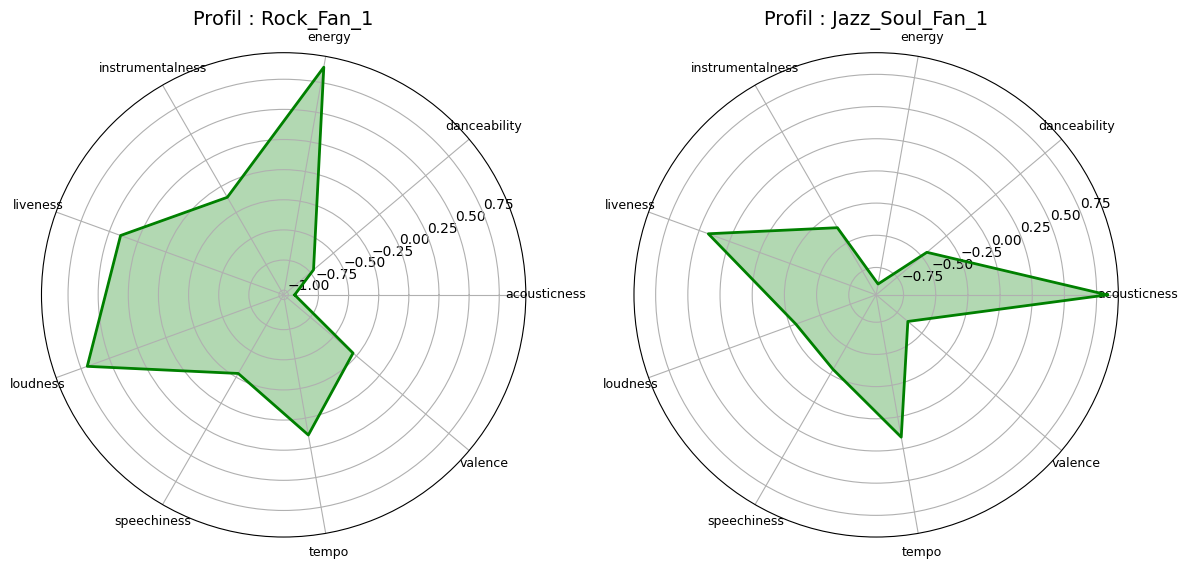

In [29]:
u_rock = next(u for u in user_pool if "Rock" in u.user_id)
u_jazz = next(u for u in user_pool if "Jazz" in u.user_id)
plot_profiles_side_by_side([u_rock, u_jazz], engine)

On observe ici la forme des goûts  
C'est cette géométrie que le Moteur de Contenu (Y) utilise pour trouver des jumeaux sonores.

#### Génération de la playlist hybride
La playlist finale est un équilibre entre :

- W (Artiste) : La zone de confort

- X (Collaboratif) : La découverte en fonction des autres utilisateurs

- Y (Contenu) : La cohérence sonore

- Z (Exploration) : La sortie de la bulle de filtre

In [30]:
user_test = next(u for u in user_pool if u.user_id == "User_Realiste_5")

# 30% Artiste, 50% Collab, 10% Contenu, 10% Exploration
playlist = engine.generate_hybrid_playlist(
    user_test, 
    user_pool, 
    total_songs=10, 
    weights=(0.3, 0.5, 0.1, 0.1)
    )

print(f"Artistes favoris de {user_test.user_id} :\n{user_test.get_top_artists(n=10)}")

display(playlist)

Artistes favoris de User_Realiste_5 :
['nikos gounaris', 'fotis polimeris', 'the beach boys', 'sublime', 'los secretos', 'captain & tennille', 'manna dey', 'allman brothers band', 'sakis pippidis', 'young gunz']


,name,artists,year,cluster,popularity
0,Cheers (Drink To That),['Rihanna'],2010,4,51
1,Swimming Pools (Drank),['Kendrick Lamar'],2012,10,49
2,Have Yourself a Merry Little Christmas,['Keston Cobblers Club'],2015,14,58
3,Where Are Ü Now (with Justin Bieber),"['Jack Ü', 'Skrillex', 'Diplo', 'Justin Bieber']",2015,8,74
4,Yeh Dosti Hum Nahin - Happy Version/From “Shol...,"['Kishore Kumar', 'Manna Dey']",1975,1,44
5,Rise,['Katy Perry'],2016,9,64
6,Wake Up Everybody (feat. Teddy Pendergrass),"['Harold Melvin & The Blue Notes', 'Teddy Pend...",1975,4,57
7,Ramblin' Man,['Allman Brothers Band'],1989,2,70
8,This Is What You Came For,"['Calvin Harris', 'Rihanna']",2017,9,22
9,Gia mas kelaidoun ta poulia,['Nikos Gounaris'],1950,0,4


La playlist doit présenter un mélange de noms connus de l'utilisateur et de nouveaux noms. La présence de titres venant d'artistes différents mais avec des sonorités proches valide l'efficacité du mélange des 4 sources.

#### Nouvel utilisateur et diversité initiale
Pour un nouvel utilisateur (0 like), le moteur passe en mode Exploration. Au lieu de donner le Top 50 global, il pioche le meilleur titre de chaque cluster (genre) différent pour sonder les goûts du nouvel arrivant.

In [31]:
new_user = User("Nouvel_Utilisateur")

print("Playlist proposée à un utilisateur inconnu :")
playlist_new = engine.generate_hybrid_playlist(
    new_user, 
    user_pool, 
    total_songs=10
    )

display(playlist_new)

Playlist proposée à un utilisateur inconnu :


,name,artists,year,popularity
17606,"Free Fallin' - Live at the Nokia Theatre, Los ...",['John Mayer'],2008,73
19592,You Are The Reason,['Calum Scott'],2018,82
57672,i'm closing my eyes,['potsu'],2017,73
19894,Levitating (feat. DaBaby),"['Dua Lipa', 'DaBaby']",2020,90
18942,Rolling Ocean Waves,"['Ocean Waves For Sleep', 'Ocean Sounds Collec...",2015,72
15862,Yellow,['Coldplay'],2000,85
7262,Jingle Bell Rock,['Bobby Helms'],1957,85
19336,White Noise - 500 hz,['Granular'],2017,78
18864,Electric Love,['BØRNS'],2015,85
19512,the remedy for a broken heart (why am I so in ...,['XXXTENTACION'],2018,83


Le succès de ce test se voit à la colonne `artists` : si la liste contient des genres très variés (ex: un titre classique, un titre rap, un titre rock), alors le moteur remplit sa mission de sondage.

#### Stratégie de Profilage et Identité Musicale

L'un des défis de ce dataset est l'absence de labels de "genres" normalisés. Pour pallier cela, nous avons implémenté une méthode de profilage par ancrage acoustique.

- Ancres de genres : Nous avons défini des signatures sonores de référence en calculant le centroïde audio d'artistes de référence (ex: Mozart pour le classique, Metallica pour le rock).

- Calcul d'identité : Le profil de l'utilisateur (moyenne de ses titres likés) est comparé à ces ancres via une similarité cosinus.

- Hybridation : Si deux scores sont proches, le système attribue une identité double (ex: "Rock & Rap/Hip-Hop").

In [32]:
search_input = widgets.Text(placeholder='Tapez un titre ou un artiste...', description='Recherche:')
search_button = widgets.Button(description="Chercher", button_style='info')
output_search = widgets.Output()

user_interactif = User("Testeur")

def on_search_clicked(b):
    with output_search:
        clear_output()
        query = search_input.value
        if len(query) < 3:
            print("Veuillez entrer au moins 3 caractères")
            return
        
        results = engine.df[
            (engine.df['name'].str.contains(query, case=False)) | 
            (engine.df['artists'].str.contains(query, case=False))
        ].head(10)
        
        if results.empty:
            print("Aucun morceau trouvé")
        else:
            options = [(f"{row['name']} - {row['artists']}", idx) for idx, row in results.iterrows()]
            selection = widgets.Dropdown(options=options, description='Résultats:')
            add_button = widgets.Button(description="Liker ce titre", button_style='success')
            
            def on_add_clicked(ab):
                idx = selection.value
                row = engine.df.loc[idx]
                user_interactif.add_liked_song(row, idx)
                with output_search:
                    print(f"Ajouté : {row['name']}")
            
            add_button.on_click(on_add_clicked)
            display(selection, add_button)

search_button.on_click(on_search_clicked)

display(widgets.VBox([search_input, search_button, output_search]))

In [33]:
mathieu = User("Mathieu")

my_favorite = [
    ("My Own Summer", "Deftones"),
    ("Swerve City", "Deftones"),
    ("Headup", "Deftones"),
    ("Robbery", "Juice WRLD"),
    ("Breed", "Nirvana"),
    ("Enter Sandman", "Metallica"),
    ("Sweet Child O' Mine", "Guns N' Roses"),
    ("Welcome To The Jungle", "Guns N' Roses"),
    ("All The Small Things", "blink-182"),
    ("What's My Age Again?", "blink-182"),
    ("Jocelyn Flores", "XXXTENTACION"),
    ("Everybody Dies In Their Nightmares", "XXXTENTACION"),
    ("SAD!", "XXXTENTACION"),
    ("Everything In Its Right Place", "Radiohead"),   
    ("Kids", "MGMT"),
    ("Diamond Eyes", "Deftones"),
    ("Snowman", "WYS"),
    ("Walking Disaster", "Sum 41"),
    ("Pieces", "Sum 41"),
    ("American Idiot", "Green Day"),
    ("Everlong", "Foo Fighters"),
    ("D.A.N.C.E", "Justice"),
    ("Save That Shit", "Lil Peep"),
    ("Magnolia", "Playboi Carti")

]

for titre, artiste in my_favorite:
    find_and_add(titre, artiste, mathieu, engine)

Ajouté : My Own Summer (Shove It) - ['Deftones']
Ajouté : Swerve City - ['Deftones']
Ajouté : Headup - ['Deftones']
Ajouté : Robbery - ['Juice WRLD']
Ajouté : Breed - ['Nirvana']
Ajouté : Enter Sandman - ['Metallica']
Ajouté : Sweet Child O' Mine - ["Guns N' Roses"]
Ajouté : Welcome To The Jungle - ["Guns N' Roses"]
Ajouté : All The Small Things - ['blink-182']
Ajouté : What's My Age Again? - ['blink-182']
Ajouté : Jocelyn Flores - ['XXXTENTACION']
Ajouté : Everybody Dies In Their Nightmares - ['XXXTENTACION']
Ajouté : SAD! - ['XXXTENTACION']
Ajouté : Everything In Its Right Place - ['Radiohead']
Ajouté : Kids - ['MGMT']
Ajouté : Diamond Eyes - ['Deftones']
Ajouté : Snowman - ['WYS']
Ajouté : Walking Disaster - ['Sum 41']
Ajouté : Pieces - ['Sum 41']
Ajouté : American Idiot - ['Green Day']
Ajouté : Everlong - ['Foo Fighters']
Ajouté : D.A.N.C.E - ['Justice']
Ajouté : Save That Shit - ['Lil Peep']
Ajouté : Magnolia - ['Playboi Carti']


#### Évaluation Visuelle et Diagnostic

Cette cellule génère un Radar Chart comparant les caractéristiques de l'utilisateur à sa catégorie détectée, puis produit la playlist finale.

Identité détectée : Rock


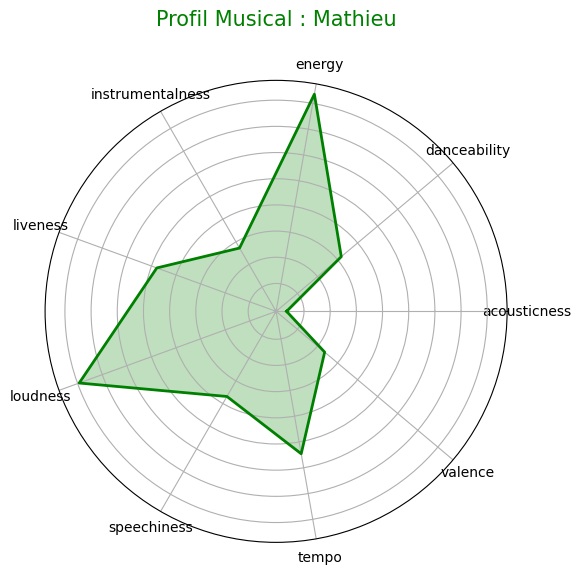

,name,artists,year,cluster,popularity
0,Separate Ways (Worlds Apart),['Journey'],1983,9,66
1,The Fellowship Reunited (feat. Sir James Galwa...,['Howard Shore'],2003,5,52
2,What Do You Do for Money Honey,['AC/DC'],1980,13,61
3,Spotlight,"['Marshmello', 'Lil Peep']",2018,13,75
4,When You Were Young,['The Killers'],2006,9,75
5,Lucid Dreams,['Juice WRLD'],2018,9,88
6,Vain Glory Opera,['Edguy'],1998,8,49
7,Smells Like Teen Spirit,['Nirvana'],1991,9,76
8,"Bad Boy Boogie - Live at the Apollo Theatre, G...",['AC/DC'],1978,13,35
9,The Eve of the War (feat. Richard Burton & Jus...,"['Jeff Wayne', 'Richard Burton', 'Justin Haywa...",1978,9,47


In [34]:
target_user = user_interactif if len(user_interactif.liked_indices) > 0 else mathieu
target_user = mathieu
identite = target_user.get_musical_identity(engine)
print(f"Identité détectée : {identite}")

target_user.plot_profile(engine)

playlist = engine.generate_hybrid_playlist(target_user, user_pool)
display(playlist)

Après avoir généré votre playlist, vous pourrez observer :  

- La Cohésion Acoustique : Grâce au module Y, la playlist conserve une homogénéité dans les caractéristiques comme le `tempo` ou l'`energy`.

- L'Efficacité du filtrage collaboratif : Le module X (pondéré par notre similarité hybride Artiste + Audio) permet de suggérer des titres même si vous n'avez aucune chanson en commun avec le pool d'utilisateurs.

- La Lutte contre la redondance : Notre filtre de post-processing garantit qu'aucune version alternative (Remaster, Radio) d'un titre déjà présent ne vienne polluer la playlist

### **Conclusion** : Choix de la configuration par défaut

Pour ce moteur, nous avons opté pour une configuration équilibrée privilégiant la cohérence sonore et la sagesse sociale, tout en assurant un ancrage rassurant sur les artistes connus.  
Pondération retenue :  
- $w = 0.2$ (Affinité artiste) : 20% de la playlist sert de "point d'ancrage" avec des morceaux d'artistes que l'utilisateur aime déjà.
- $x = 0.3$ (Collaboratif) : 30% des suggestions proviennent du pool d'utilisateurs. Ce poids est modéré pour éviter de diluer la playlist si les voisins sont trop hétéroclites.  
- $y = 0.4$ (Contenu audio) : 40% de la recommandation repose sur la similarité acoustique. C'est ce qui garantit une continuité dans l'énergie et le tempo de la playlist.  
- $z = 0.1$ (Exploration) : 10% de découverte pure pour stimuler la curiosité, le sonder et le sortir des bulles de filtre.

### Limites Actuelles et Pistes d'Amélioration

Bien que robuste, notre prototype de moteur de recommandation peut être optimisé pour se rapprocher des standards actuels (Spotify, Deezer).

#### 1. Gestion de la "Fatigue" et Tabu List
Actuellement, si une chanson est recommandée mais que l'utilisateur ne la like pas, le moteur peut la proposer à nouveau indéfiniment.  
Amélioration :   
Implémenter une **Tabu List**. Chaque morceau recommandé verrait son score de priorité chuter drastiquement pour les $n$ prochaines sessions afin de ne pas saturer l'utilisateur avec des titres qu'il connaît déjà mais ne souhaite pas intégrer à sa bibliothèque.

#### 2. Absence de feedback négatif
Notre modèle ne traite que les interactions positives (Likes).  
Amélioration :  
Ajouter une fonction "Dislike" ou "Passer le morceau".

#### 3. Prise en compte de la temporalité
Actuellement, un like d'il y a 3 ans a le même poids qu'un like d'hier.  
Amélioration :   
Appliquer une **décroissance temporelle**. Les goûts musicaux évoluent, les interactions récentes devraient avoir un impact plus fort sur le calcul du centroïde de l'utilisateur que ses écoutes passées.

#### 4. Optimisation de la performance (scalabilité)
Le calcul de la similarité cosinus sur l'ensemble du dataset à chaque requête devient coûteux si le catalogue contient beaucoup de titres et si on a beaucoup d'utilisateurs.  
Amélioration :   
Utiliser des algorithmes de recherche de plus proches voisins approximatifs pour une réponse plus rapide.